# The Best Format to Save Pandas Data

In [1]:
!cat /proc/cpuinfo | grep -m1 "model name"
!lscpu | grep -m1 "CPU(s)"
!awk '$3=="kB"{$2=$2/1024^2;$3="GB";} 1' /proc/meminfo | column -t | grep "MemTotal"

model name	: Intel(R) Xeon(R) CPU
CPU(s):                          4
MemTotal:           15.6376      GB


In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from collections import defaultdict
import os

In [4]:
import feather
import numpy as np
import pandas as pd
import seaborn as sns
import pyarrow
import tables

In [5]:
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Feather version: {feather.__version__}")
print(f"Pyarrow version: {pyarrow.__version__}")
print(f"Pytables version: {tables.__version__}")

Pandas version: 1.2.4
Numpy version: 1.20.2
Feather version: 0.4.1
Pyarrow version: 3.0.0
Pytables version: 3.6.1


In [6]:
from utils import Timer, MemoryTracker, GC, NotebookStyle

In [7]:
style = NotebookStyle()
style.override({'grid.color': 'lightgray'})

## Random Dataset

In [8]:
def generate_dataset(n_rows, num_count, cat_count, max_nan=0.1, max_cat_size=100):
    """Randomly generate datasets with numerical and categorical features.
    
    The numerical features are taken from the normal distribution X ~ N(0, 1).
    The categorical features are generated as random uuid4 strings with 
    cardinality C where 2 <= C <= max_cat_size.
    
    Also, a max_nan proportion of both numerical and categorical features is replaces
    with NaN values.
    """
    dataset, types = {}, {}
    
    def generate_categories():
        from uuid import uuid4
        category_size = np.random.randint(2, max_cat_size)
        return [str(uuid4()) for _ in range(category_size)]
    
    for col in range(num_count):
        name = f'n{col}'
        values = np.random.normal(0, 1, n_rows)
        nan_cnt = np.random.randint(1, int(max_nan*n_rows))
        index = np.random.choice(n_rows, nan_cnt, replace=False)
        values[index] = np.nan
        dataset[name] = values
        types[name] = 'float32'
        
    for col in range(cat_count):
        name = f'c{col}'
        cats = generate_categories()
        values = np.array(np.random.choice(cats, n_rows, replace=True), dtype=object)
        nan_cnt = np.random.randint(1, int(max_nan*n_rows))
        index = np.random.choice(n_rows, nan_cnt, replace=False)
        values[index] = np.nan
        dataset[name] = values
        types[name] = 'object'
    
    return pd.DataFrame(dataset), types

## Benchmarking

In [9]:
def size_of(filename, unit=1024**2):
    return round(os.stat(filename).st_size / unit, 2)

In [10]:
def get_save_load(df, fmt):
    save = getattr(df, f'to_{fmt}')
    load = feather.read_dataframe if fmt == 'feather' else getattr(pd, f'read_{fmt}')
    return save, load

In [11]:
def benchmark(list_of_formats, data_size=1_000_000, n_num=15, n_cat=15, n_rounds=20,
              as_category=False):
    """Runs dataset saving/loading benchamrk using formts from the list_of_formats.
    
    Each round a new random dataset is generated with data_size observations. 
    The measurements for each of the rounds are concatenated together and returned
    as a single data frame.
    
    Parameters:
        list_of_formats: A list of tuples in the format (<format_name>, [<params_dict>]). 
            The <format_name> should be one of the pandas supported formats.
        data_size: A number of samples in the generated dataset.
        n_num: A number of numerical columns in the generated dataset.
        n_cat: A number of categorical columns in the generated dataset.
        n_rounds: A number of randomly generated datasets to test the formats.
        as_category: If True, then categorical columns will be converted into 
            pandas.Category type before saving.
            
    """
    runs = []
    
    for i in range(n_rounds):
        print(f'Benchmarking round #{i + 1:d}')
        print('\tgenerating dataset...')
        dataset, _ = generate_dataset(data_size, n_num, n_cat)
        
        if as_category:
            print('\tconverting categorical columns into pandas.Category')
            cat_cols = dataset.select_dtypes(include=object).columns
            dataset[cat_cols] = dataset[cat_cols].fillna('none').astype('category')
        
        benchmark = []
        
        for case in list_of_formats:
            fmt, params = case if len(case) == 2 else (case[0], {})
            
            with GC():
                print('\ttesting format:', fmt)
                filename = f'random.{fmt}'
                save, load = get_save_load(dataset, fmt)
                results = defaultdict(int)
                results['format'] = fmt
                results['filename'] = filename
                
                with MemoryTracker() as tracker:
                    with Timer() as timer:
                        save(filename, **params)
                results['size_mb'] = size_of(filename)
                results['save_ram_delta_mb'] = tracker.memory / (1024 ** 2)
                results['save_time'] = float(timer)
                
                with MemoryTracker() as tracker:
                    with Timer() as timer:
                        _ = load(filename)
                results['load_ram_delta_mb'] = tracker.memory / (1024 ** 2)
                results['load_time'] = float(timer)
                
                benchmark.append(results)
                
            run = pd.DataFrame(benchmark)
            run['run_no'] = i
            runs.append(run)
            
    benchmark = pd.concat(runs, axis=0)
    benchmark.reset_index(inplace=True, drop=True)
    return benchmark

### CSV Baseline

In [12]:
formats = [('csv', {'index': None})]

In [13]:
csv_results = benchmark(formats, n_rounds=5)

Benchmarking round #1
	generating dataset...
	testing format: csv
Benchmarking round #2
	generating dataset...
	testing format: csv
Benchmarking round #3
	generating dataset...
	testing format: csv
Benchmarking round #4
	generating dataset...
	testing format: csv
Benchmarking round #5
	generating dataset...
	testing format: csv


In [14]:
csv_results.to_feather('baseline.feather')

In [15]:
baseline = feather.read_dataframe('baseline.feather')

In [16]:
baseline

,format,filename,size_mb,save_ram_delta_mb,save_time,load_ram_delta_mb,load_time,run_no
0,csv,random.csv,767.06,4.109375,29.188696,497.312500,7.157136,0
1,csv,random.csv,766.12,-0.023438,33.779919,514.394531,6.752042,1
2,csv,random.csv,769.98,-0.269531,30.113655,506.898438,6.838138,2
3,csv,random.csv,768.64,-0.019531,31.658011,514.597656,6.799700,3
4,csv,random.csv,773.26,-0.023438,34.327565,514.625000,6.855822,4


### Categoricals As Strings

In [17]:
formats = [
    ('hdf', {'key': 'data', 'format': 'table'}),
    ('pickle',),
#     ('msgpack',),
    ('feather',),
    ('parquet', {'engine': 'pyarrow'})
]

In [18]:
results = benchmark(formats)

Benchmarking round #1
	generating dataset...
	testing format: hdf
	testing format: pickle
	testing format: feather
	testing format: parquet
Benchmarking round #2
	generating dataset...
	testing format: hdf
	testing format: pickle
	testing format: feather
	testing format: parquet
Benchmarking round #3
	generating dataset...
	testing format: hdf
	testing format: pickle
	testing format: feather
	testing format: parquet
Benchmarking round #4
	generating dataset...
	testing format: hdf
	testing format: pickle
	testing format: feather
	testing format: parquet
Benchmarking round #5
	generating dataset...
	testing format: hdf
	testing format: pickle
	testing format: feather
	testing format: parquet
Benchmarking round #6
	generating dataset...
	testing format: hdf
	testing format: pickle
	testing format: feather
	testing format: parquet
Benchmarking round #7
	generating dataset...
	testing format: hdf
	testing format: pickle
	testing format: feather
	testing format: parquet
Benchmarking round #

In [19]:
results.to_feather('one_million_cats_str.feather')

In [20]:
results = feather.read_dataframe('one_million_cats_str.feather')

In [21]:
results = pd.concat([baseline, results], axis=0, sort=False)

In [22]:
avg = results.groupby('format').mean().reset_index().drop(columns=['run_no'])
avg

,format,size_mb,save_ram_delta_mb,save_time,load_ram_delta_mb,load_time
0,csv,769.0120,0.754687,31.813569,509.565625,6.880568
1,feather,225.5015,706.273242,13.093979,877.545313,1.848458
2,hdf,637.7515,1225.353516,12.355667,2809.283984,13.227936
3,parquet,125.3435,119.489063,3.528444,904.445703,1.050796
4,pickle,651.3920,767.725195,15.730561,1121.995117,4.591625


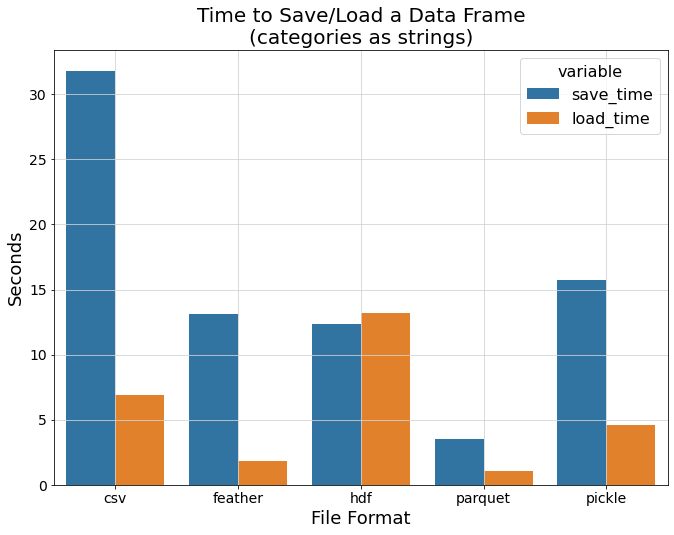

In [23]:
io_speed = avg[['format', 'save_time', 'load_time']].melt(id_vars='format')
ax = sns.barplot(x='format', y='value', hue='variable', data=io_speed)
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Seconds')
_ = ax.set_title('Time to Save/Load a Data Frame\n(categories as strings)')
ax.grid(True)

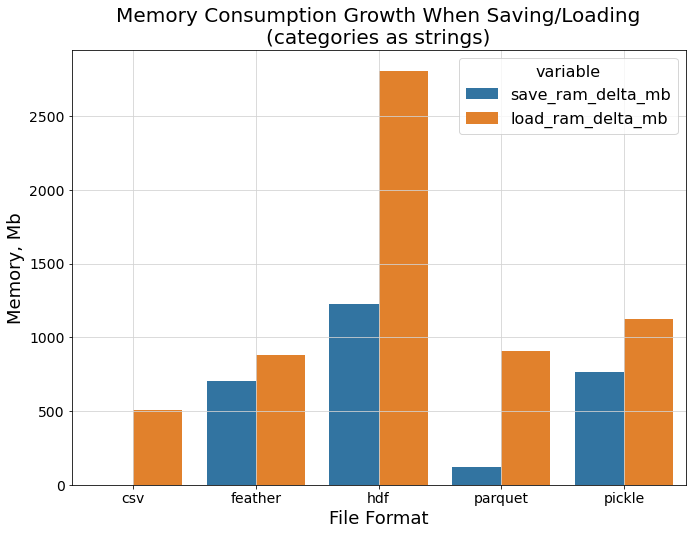

In [24]:
mem_size = avg[['format', 'save_ram_delta_mb', 'load_ram_delta_mb']].melt(id_vars='format')
ax = sns.barplot(x='format', y='value', hue='variable', data=mem_size)
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Memory, Mb')
ax.set_title('Memory Consumption Growth When Saving/Loading\n(categories as strings)')
ax.grid(True)

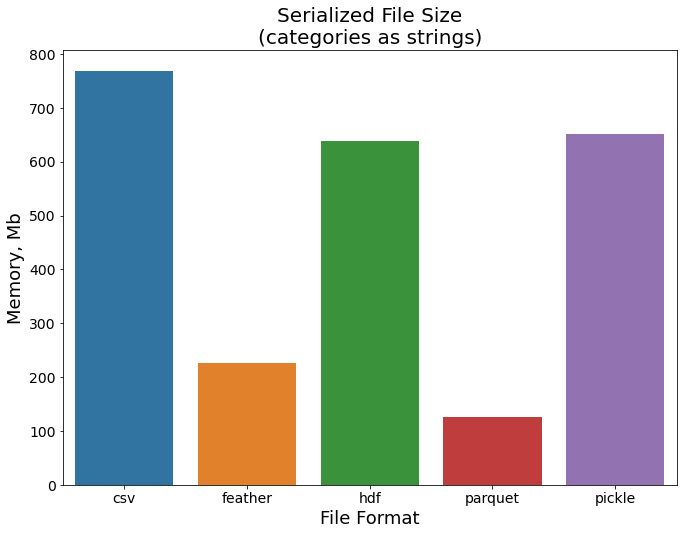

In [25]:
ax = sns.barplot(x='format', y='size_mb', data=avg)
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Memory, Mb')
_ = ax.set_title('Serialized File Size\n(categories as strings)')

### Categoricals As Dedicated Category Type

In [26]:
results = benchmark(formats, as_category=True)

Benchmarking round #1
	generating dataset...
	converting categorical columns into pandas.Category
	testing format: hdf
	testing format: pickle
	testing format: feather
	testing format: parquet
Benchmarking round #2
	generating dataset...
	converting categorical columns into pandas.Category
	testing format: hdf
	testing format: pickle
	testing format: feather
	testing format: parquet
Benchmarking round #3
	generating dataset...
	converting categorical columns into pandas.Category
	testing format: hdf
	testing format: pickle
	testing format: feather
	testing format: parquet
Benchmarking round #4
	generating dataset...
	converting categorical columns into pandas.Category
	testing format: hdf
	testing format: pickle
	testing format: feather
	testing format: parquet
Benchmarking round #5
	generating dataset...
	converting categorical columns into pandas.Category
	testing format: hdf
	testing format: pickle
	testing format: feather
	testing format: parquet
Benchmarking round #6
	generating d

In [27]:
results.to_feather('one_million_cats_category.feather')

In [28]:
results  = feather.read_dataframe('one_million_cats_category.feather')

In [29]:
results = pd.concat([baseline, results], axis=0)

In [30]:
avg = results.groupby('format').mean().reset_index().drop(columns=['run_no'])
avg

,format,size_mb,save_ram_delta_mb,save_time,load_ram_delta_mb,load_time
0,csv,769.0120,0.754687,31.813569,509.565625,6.880568
1,feather,126.3525,16.347461,1.837974,246.404883,0.179533
2,hdf,638.4150,6.179297,0.935720,235.175195,0.845009
3,parquet,124.4595,50.639453,3.164805,415.695703,0.319350
4,pickle,128.7775,-0.023438,0.855143,78.980469,0.092545


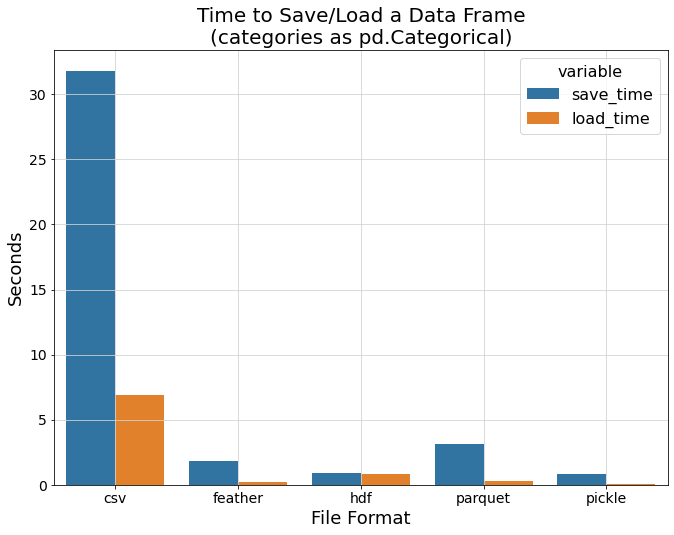

In [31]:
io_speed = avg[['format', 'save_time', 'load_time']].melt(id_vars='format')
ax = sns.barplot(x='format', y='value', hue='variable', data=io_speed)
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Seconds')
_ = ax.set_title('Time to Save/Load a Data Frame\n(categories as pd.Categorical)')
ax.grid(True)

In [32]:
results = feather.read_dataframe('one_million_cats_category.feather')

In [33]:
avg = results.groupby('format').mean().reset_index().drop(columns=['run_no'])

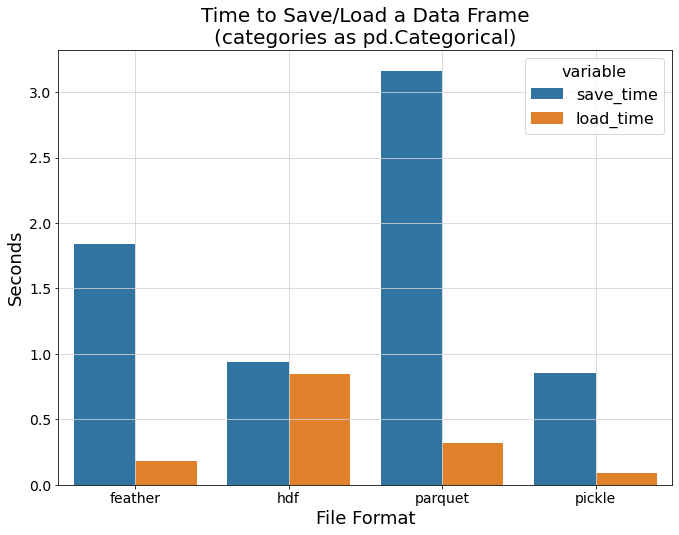

In [34]:
io_speed = avg[['format', 'save_time', 'load_time']].melt(id_vars='format')
ax = sns.barplot(x='format', y='value', hue='variable', data=io_speed)
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Seconds')
_ = ax.set_title('Time to Save/Load a Data Frame\n(categories as pd.Categorical)')
ax.grid(True)

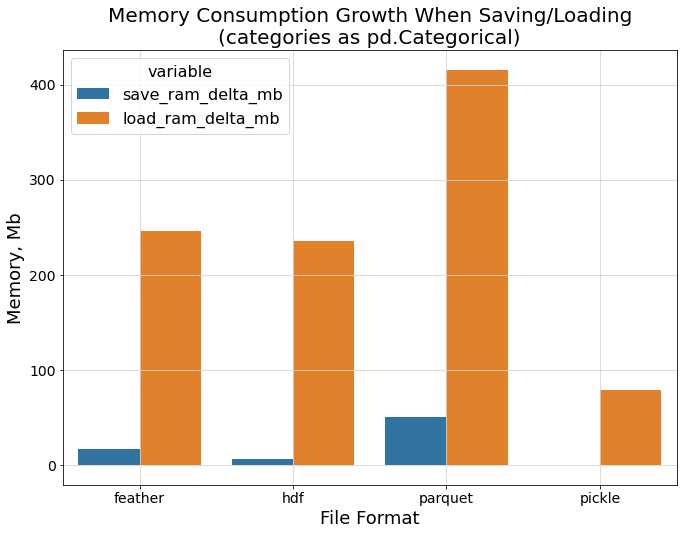

In [35]:
mem_size = avg[['format', 'save_ram_delta_mb', 'load_ram_delta_mb']].melt(id_vars='format')
ax = sns.barplot(x='format', y='value', hue='variable', data=mem_size)
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Memory, Mb')
ax.set_title('Memory Consumption Growth When Saving/Loading\n(categories as pd.Categorical)')
ax.grid(True)

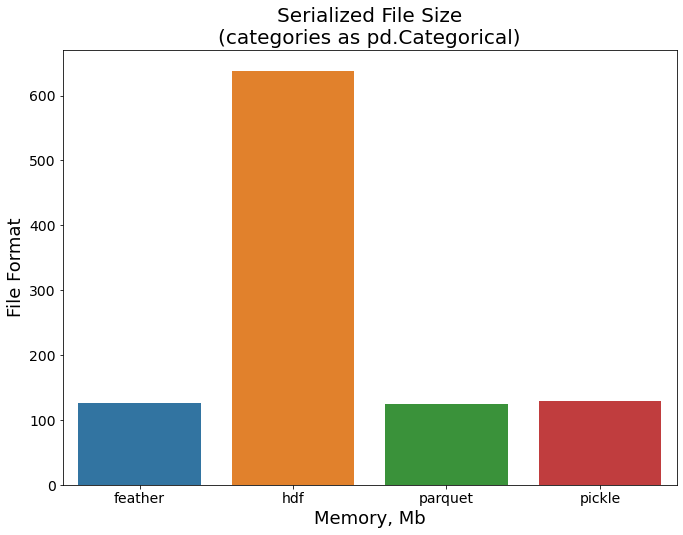

In [36]:
ax = sns.barplot(x='format', y='size_mb', data=avg)
_ = ax.set_xlabel('Memory, Mb')
_ = ax.set_ylabel('File Format')
_ = ax.set_title('Serialized File Size\n(categories as pd.Categorical)')